# Imports

In [1]:
# Import dependencies
from __future__ import absolute_import, division, print_function
import codecs # word encoding
import glob  # regex
import multiprocessing 
import os
import pprint
import re
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/aman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/aman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Prepare corpus

In [3]:
book_filenames = sorted(glob.glob("data/*.txt"))
print(book_filenames)

['data/got1.txt', 'data/got2.txt', 'data/got3.txt', 'data/got4.txt', 'data/got5.txt']


In [4]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, 'r', 'utf-8') as book_file:
        corpus_raw += book_file.read()
    print('Corpus is now {0} characters long'.format(len(corpus_raw)))
    print()

Reading 'data/got1.txt'...
Corpus is now 1770659 characters long

Reading 'data/got2.txt'...
Corpus is now 4071041 characters long

Reading 'data/got3.txt'...
Corpus is now 6391405 characters long

Reading 'data/got4.txt'...
Corpus is now 8107945 characters long

Reading 'data/got5.txt'...
Corpus is now 9719485 characters long



In [5]:
tokenizer = nltk.data.load('/home/aman/nltk_data/tokenizers/punkt/english.pickle')

In [6]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [7]:
def sentence_to_wordlist(raw):
    clean = re.sub('[^a-zA-Z]', " ", raw)
    words = clean.split()
    return words

In [8]:
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
         sentences.append(sentence_to_wordlist(raw_sentence))

In [9]:
token_count = sum([len(sentence) for sentence in sentences])
print(token_count)

1818103


# Train word2vec

In [10]:
num_features = 300
min_word_count = 3
num_workers = multiprocessing.cpu_count()
context_size = 7
downsampling = 1e-3   # for frequent words
seed = 1


In [11]:
thrones2vec = w2v.Word2Vec(sg=1,seed=seed,
                           workers=num_workers,
                           size=num_features,
                           min_count=min_word_count,
                           window=context_size,
                           sample=downsampling)

In [12]:
thrones2vec.build_vocab(sentences)

2017-05-18 18:11:42,970 : INFO : collecting all words and their counts
2017-05-18 18:11:42,972 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-05-18 18:11:43,041 : INFO : PROGRESS: at sentence #10000, processed 140984 words, keeping 10280 word types
2017-05-18 18:11:43,088 : INFO : PROGRESS: at sentence #20000, processed 279730 words, keeping 13558 word types
2017-05-18 18:11:43,136 : INFO : PROGRESS: at sentence #30000, processed 420336 words, keeping 16598 word types
2017-05-18 18:11:43,195 : INFO : PROGRESS: at sentence #40000, processed 556581 words, keeping 18324 word types
2017-05-18 18:11:43,243 : INFO : PROGRESS: at sentence #50000, processed 686247 words, keeping 19714 word types
2017-05-18 18:11:43,293 : INFO : PROGRESS: at sentence #60000, processed 828497 words, keeping 21672 word types
2017-05-18 18:11:43,347 : INFO : PROGRESS: at sentence #70000, processed 973830 words, keeping 23093 word types
2017-05-18 18:11:43,398 : INFO : PROGRESS: at 

In [13]:
thrones2vec.corpus_count

128868

In [ ]:
thrones2vec.train(sentences,total_examples=thrones2vec.corpus_count)

/usr/local/lib/python2.7/dist-packages/gensim/models/word2vec.py:651: UserWarning: C extension not loaded for Word2Vec, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn("C extension not loaded for Word2Vec, training will be slow. "
2017-05-18 18:11:59,403 : INFO : training model with 4 workers on 17277 vocabulary and 300 features, using sg=1 hs=1 sample=0.001 and negative=0
2017-05-18 18:12:02,840 : INFO : PROGRESS: at 0.08% examples, 338 words/s
2017-05-18 18:12:03,878 : INFO : PROGRESS: at 0.31% examples, 1089 words/s
2017-05-18 18:12:05,609 : INFO : PROGRESS: at 0.39% examples, 927 words/s
2017-05-18 18:12:06,860 : INFO : PROGRESS: at 0.54% examples, 1047 words/s
2017-05-18 18:12:08,925 : INFO : PROGRESS: at 0.70% examples, 1063 words/s
2017-05-18 18:12:10,974 : INFO : PROGRESS: at 0.93% examples, 1143 words/s
2017-05-18 18:12:12,296 : INFO : PROGRESS: at 1.01% examples, 1112 words/s
2017-05-18 18:12:14,710 : INFO : PROGRESS: at 1.2

In [ ]:
if not os.path.exists('trained'):
    os.makedirs('trained')


In [ ]:
thrones2vec.save(os.path.join('trained', 'thrones2vec.w2v'))

# Explore trained model

In [2]:
thrones2vec = w2v.Word2Vec.load(os.path.join("trained", "thrones2vec.w2v"))

2017-05-18 18:56:37,115 : INFO : loading Word2Vec object from trained/thrones2vec.w2v
2017-05-18 18:56:38,329 : INFO : setting ignored attribute syn0norm to None
2017-05-18 18:56:38,330 : INFO : setting ignored attribute cum_table to None


In [3]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [9]:
all_word_vectors_matrix = thrones2vec.syn0

In [10]:
# reduced due to smaller computing power
# comment this line for better results
all_word_vectors_matrix = all_word_vectors_matrix[:5000]

In [11]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [13]:
points = pd.DataFrame(
    [(word, coords[0], coords[1]) 
     for  word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.vocab[word].index])
            for word in thrones2vec.vocab if thrones2vec.vocab[word].index < 5000
        ]
    ],  columns=['word', 'x', 'y']
)

In [14]:
points.head(10)

,word,x,y
0,fawn,1.909790,-0.498305
1,writings,5.600112,-7.850160
2,Ysilla,7.755037,4.449267
3,Rory,8.425104,0.396899
4,mustachio,5.381757,-9.649451
5,Greyjoy,-5.313263,-10.710923
6,yellow,-6.672368,-11.239066
7,woods,-0.415043,-4.921278
8,clotted,5.192918,-11.879203
9,spiders,-3.584432,-0.299477


In [15]:
sns.set_context('poster')

In [16]:
points.plot.scatter('x','y', s=10, figsize=(20,12))

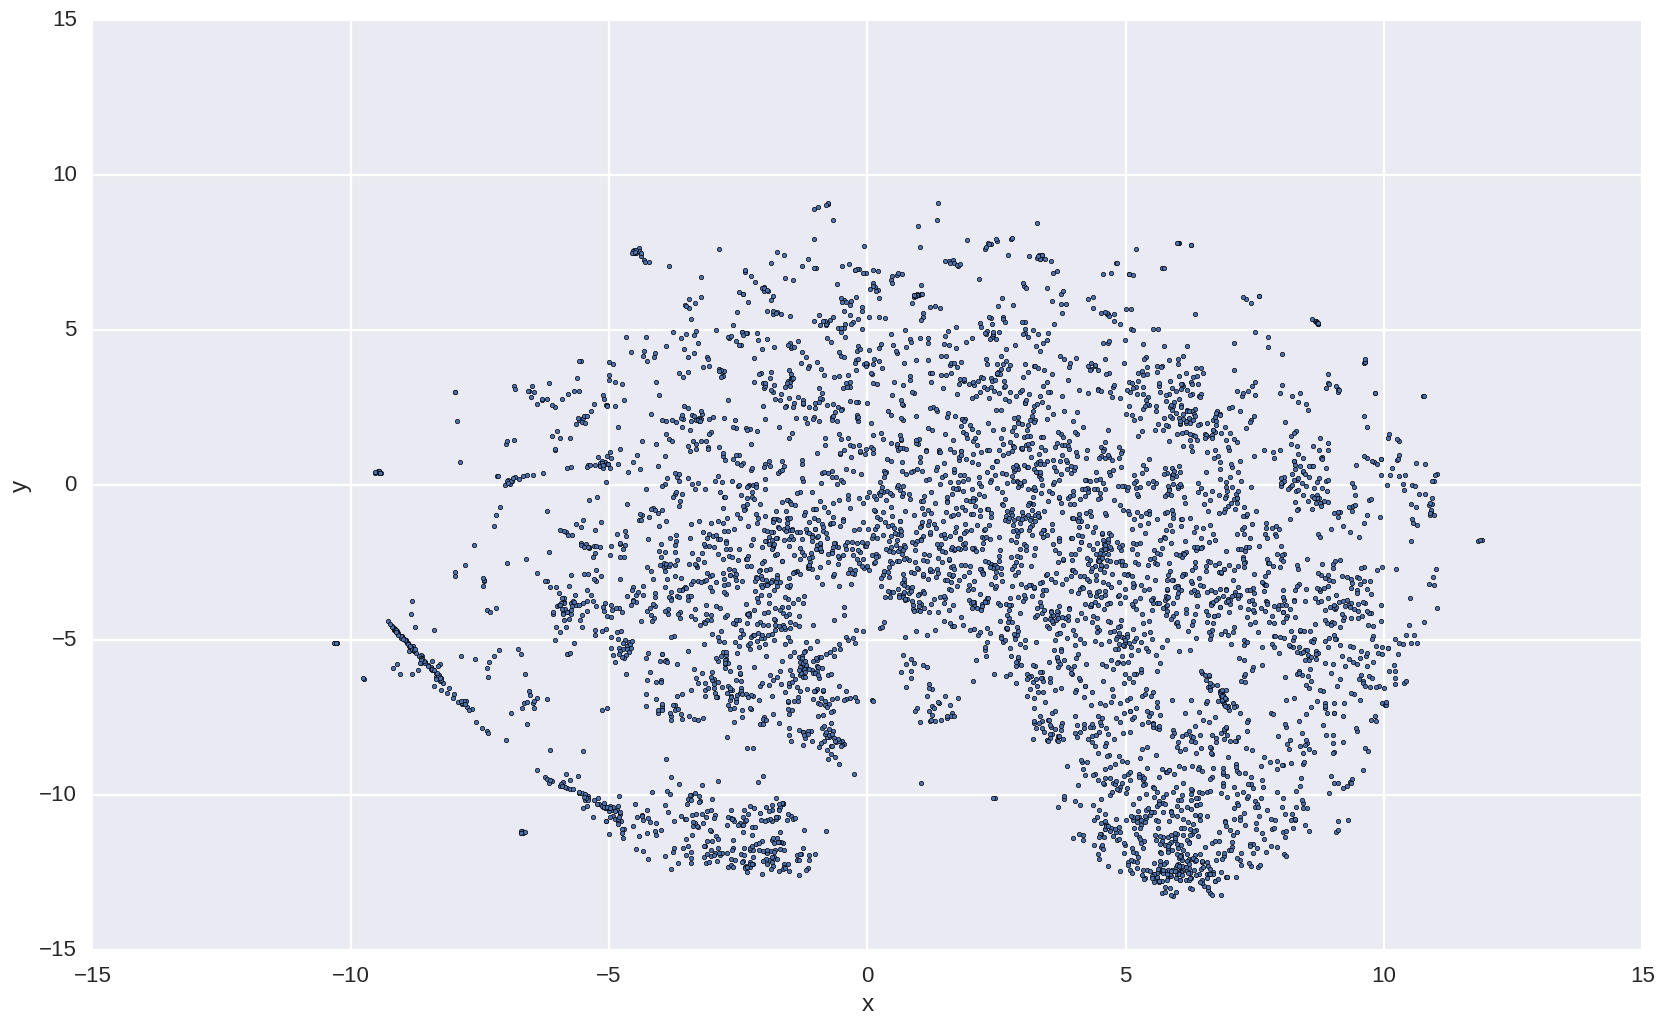

In [17]:
plt.show()

## Zoom in to interesting places

In [30]:
def plot_region(x_bounds, y_bounds):
     slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
        ]
     ax = slice.plot.scatter('x', 'y', s=35, figsize=(10,8))
     for i, point in slice.iterrows():
         ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)
     plt.show()

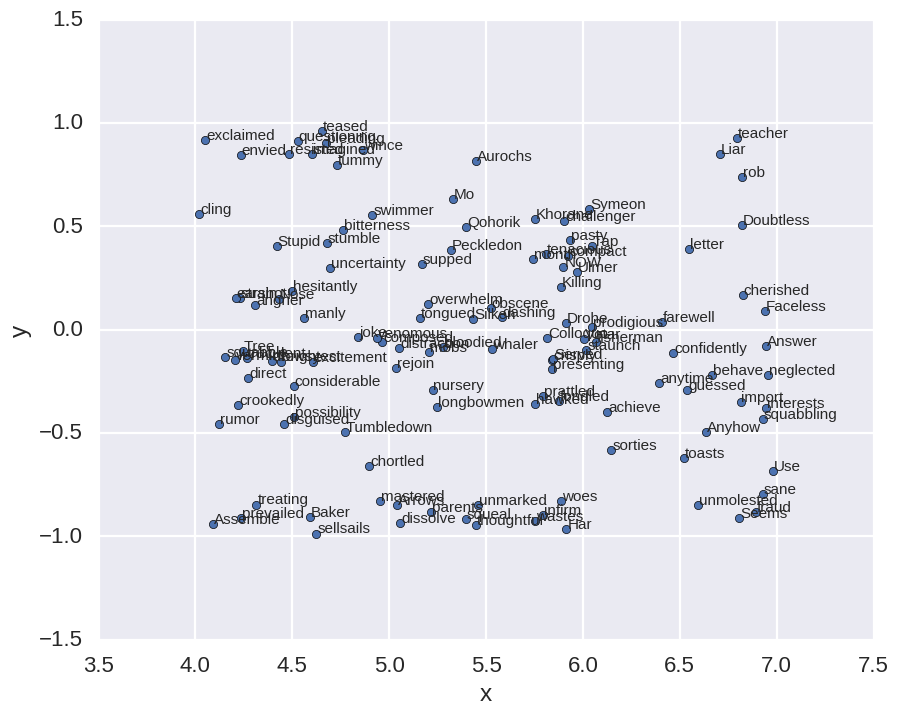

In [33]:
plot_region(x_bounds=(4.0, 7.0), y_bounds=(-1.0, 1.0))

In [34]:
thrones2vec.most_similar("direwolf")

[(u'infant', 0.5500625371932983),
 (u'GHOST', 0.5392032861709595),
 (u'SHAGGYDOG', 0.520331859588623),
 (u'guardsman', 0.5142433643341064),
 (u'Stark', 0.5109564065933228),
 (u'RICKON', 0.5107085108757019),
 (u'preening', 0.4894062876701355),
 (u'banner', 0.4866983890533447),
 (u'Table', 0.4835421144962311),
 (u'pudgy', 0.4831523299217224)]

In [35]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(positive=[end2, start1], negative=[end1])
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [36]:
nearest_similarity_cosmul("Stark", "Winterfell", "Riverrun")

Stark is related to Winterfell, as Olenna is related to Riverrun


u'Olenna'